In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

# Read

In [2]:
DARTs = [21414, 21419, 21401, 21418, 21413, 52403, 52406, 55012, 51425, 51407,
        46404, 46407, 46411, 46412, 43412, 43413, 32411, 32412,32413,32401]
# DARTs = [ 52403, 52406]
dataFrames = {}

In [3]:
len(DARTs)

20

In [4]:
for i,dartNumber in enumerate(DARTs):
    params = {
        'filepath_or_buffer': 'dart{}'.format(dartNumber),
        'skiprows': 2,
        'delim_whitespace': True,
        'names' : 'year month day hour minute second T height'.split(),
        'na_values': 9999
    }
    df = pd.read_csv(**params)
    df['date'] = pd.to_datetime(df['year month day hour minute second'.split()])
    df = df['date height'.split()]
    
    df = df.set_index('date')
    df = df.interpolate()
    dataFrames[dartNumber] = df
    

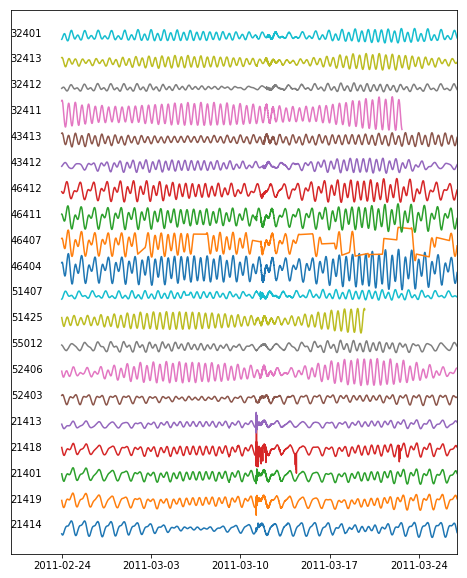

In [5]:
plt.figure(figsize=(8,10))
for i,dart in enumerate(DARTs):
    df = dataFrames[dart]
    plt.plot(df['height']-df['height'].mean()+i*2)
    plt.text(df.index.min()-pd.Timedelta(days=4),i*2,'{}'.format(dart))
    plt.ylim(-2,40)
    plt.xlim(df.index.min()-pd.Timedelta(days=4), df.index.max())
    plt.gca().set_yticks([])

# Apply high freq band filter

In [6]:
def interpolateToUniformStep(df2):
    df = df2.iloc[np.where(1-np.isnan(df2))[0]]
    t0 = df.index.to_julian_date()

    dt = np.unique(np.diff(t0[::-1]))[1:].min()
    t = np.arange(t0.min(),t0.max()+dt,dt)

    h = np.interp(t,t0[::-1],df['height'][::-1])
    return t,h

In [7]:
def filterSignal(h,cut):
    
    a = np.fft.rfft(h)
    freq = np.fft.rfftfreq(h.shape[0],d=15/60/60)
    alow = np.where(np.abs(freq)<=cut,a,0.0)
    ahigh = np.where(np.abs(freq)>cut,a,0.0)
    hlow = np.fft.irfft(alow)
    hhigh = np.fft.irfft(ahigh)
    
    nonzerolow = np.where(np.abs(alow)>1e-5)[0]
    nonzerohigh = np.where(np.abs(ahigh)>1e-5)[0]
    lowSignal = {
        'a': alow[nonzerolow],
        'h': hlow,
        'freq': freq[nonzerolow]
    }
    
    highSignal = {
        'a': ahigh[nonzerohigh],
        'h': hhigh,
        'freq': freq[nonzerohigh]
    }
    return lowSignal, highSignal

In [8]:
def getFilteredSignal(df,cut):
    t,h = interpolateToUniformStep(df)
    lowSignal, highSignal = filterSignal(h,cut)
    return lowSignal, highSignal, t, h

In [9]:
filteredSignals = {}

In [10]:
for key in dataFrames.keys():
    print(key)
    lowSignal,highSignal, t, h = getFilteredSignal(dataFrames[key], 0.3)
    filteredSignals[key] = {
        'lowSignal': lowSignal,
        'highSignal': highSignal, 
        't': t, 
        'h': h
    }

21414
21419
21401
21418
21413
52403
52406
55012
51425
51407
46404
46407
46411
46412
43412
43413
32411
32412
32413
32401


In [11]:
dataFrames.keys()

dict_keys([21414, 21419, 21401, 21418, 21413, 52403, 52406, 55012, 51425, 51407, 46404, 46407, 46411, 46412, 43412, 43413, 32411, 32412, 32413, 32401])

In [12]:
map(lambda k: k, dataFrames.keys())


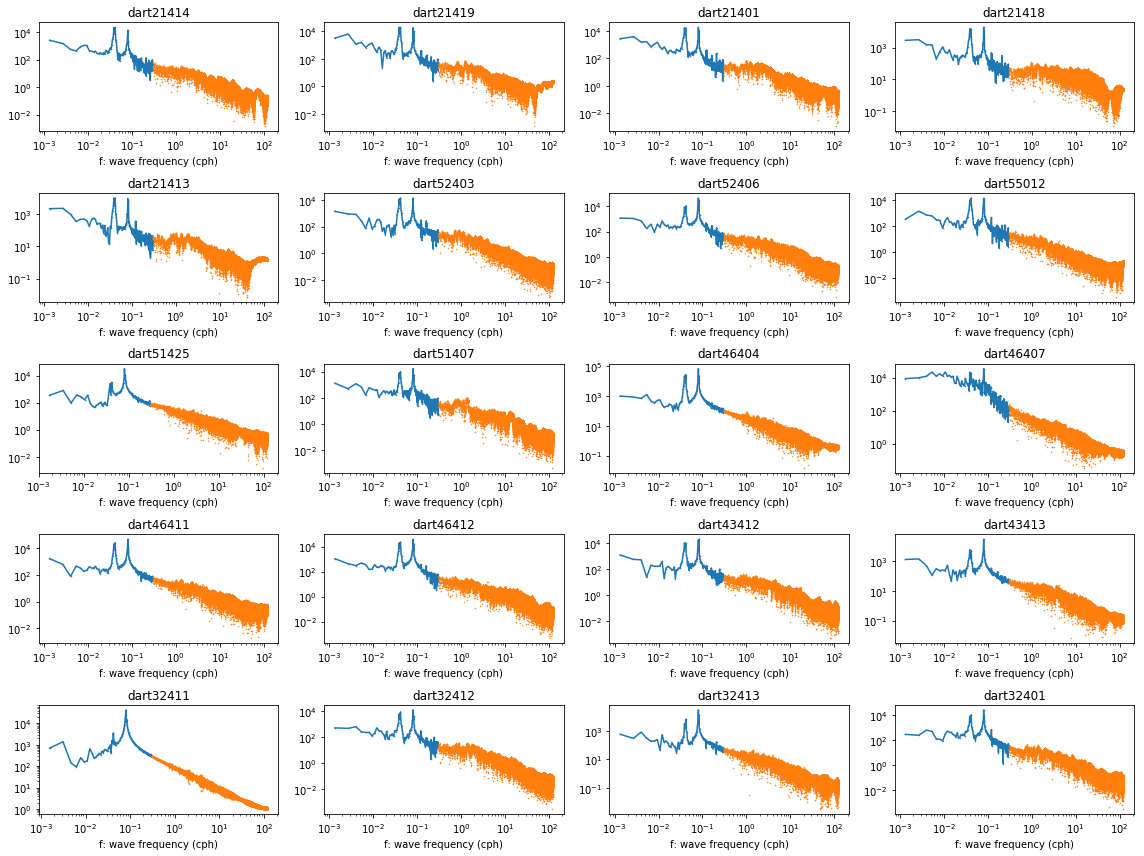

In [13]:
plt.figure(figsize=(16,12))
for i,dart in enumerate(DARTs):

    lowSignal,highSignal, t, h = (filteredSignals[dart]['lowSignal'],
                            filteredSignals[dart]['highSignal'],
                            filteredSignals[dart]['t'],
                            filteredSignals[dart]['h'] )

    plt.subplot(5,4,i+1)
    plt.plot(lowSignal['freq'][1:],np.abs(lowSignal['a'])[1:],'.-',ms=1)
    plt.plot(highSignal['freq'][1:],np.abs(highSignal['a'])[1:],'.',ms=1)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('f: wave frequency (cph)')
    plt.title('dart{}'.format(dart))
#     plt.ylim(4,14)
plt.tight_layout()
plt.savefig('dart-spectra.png',dpi=300)

In [14]:
earthquakeDate = pd.to_datetime('2011-03-11 05:46:24.120')
tearthquake = earthquakeDate.to_julian_date()

[]

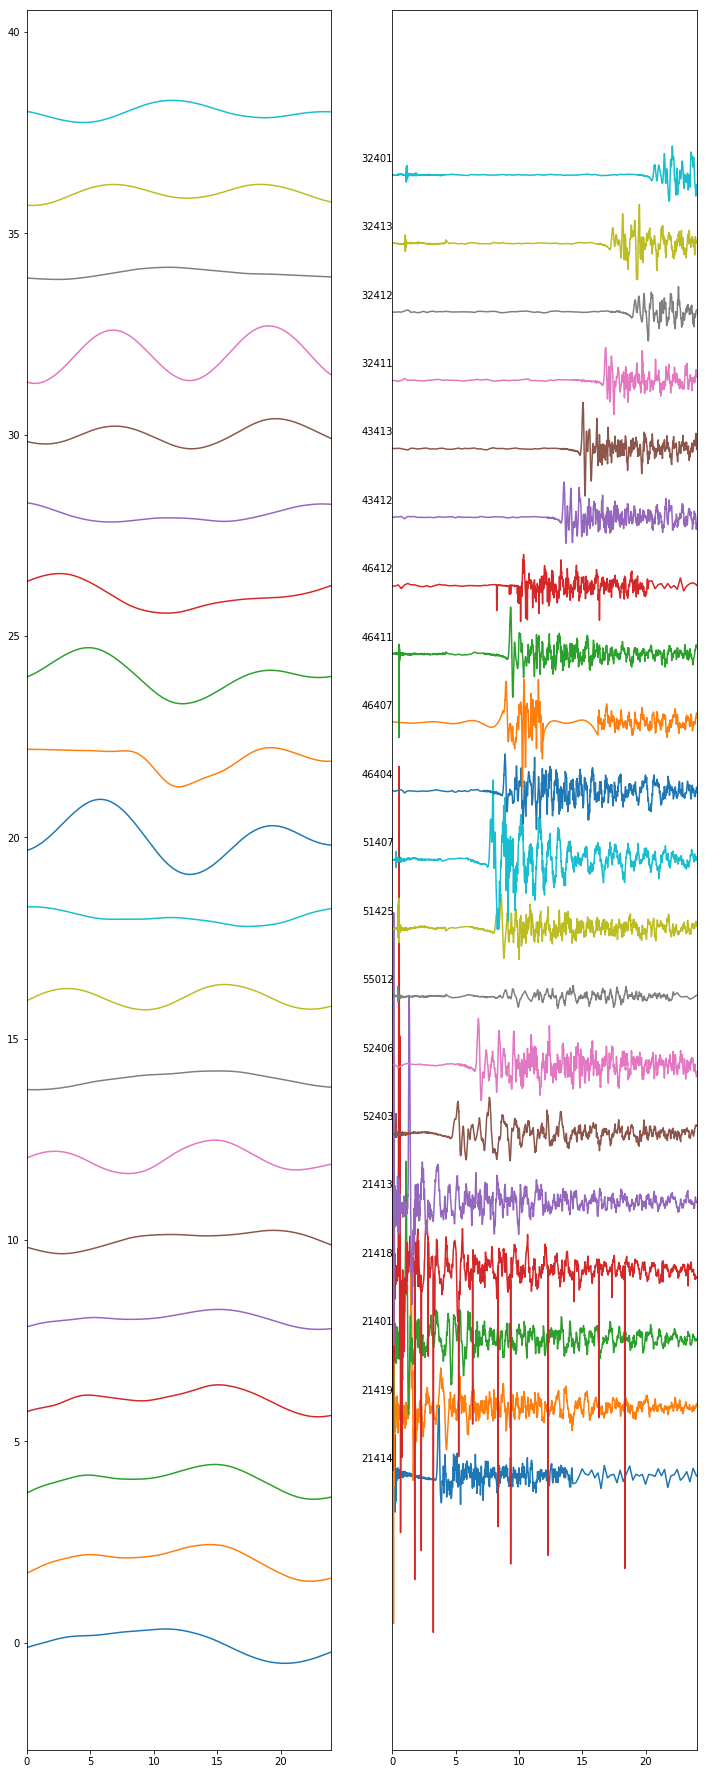

In [15]:
plt.figure(figsize=(12,32))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

for i,dart in enumerate(DARTs):
    lowSignal,highSignal, t, h = (filteredSignals[dart]['lowSignal'],
                            filteredSignals[dart]['highSignal'],
                            filteredSignals[dart]['t'],
                            filteredSignals[dart]['h'] )
    lowSignal['h'].real = lowSignal['h'].real - lowSignal['h'].real.mean() 
    df = dataFrames[dart]
    ax1.plot((t-tearthquake)*24,lowSignal['h'].real+i*2)
    ax2.plot((t-tearthquake)*24,highSignal['h'].real+i*0.25)
    ax2.text(-2.4, i*0.25+0.05, '{}'.format(dart))
# plt.ylim(-2,10)
ax1.set_xlim(0,24)
ax2.set_xlim(0,24)

ax2.set_yticks([])
# plt.gca().get_yaxis().set_visible(False)

In [17]:
for dart in DARTs:
    lowSignal,highSignal, t, h = (filteredSignals[dart]['lowSignal'],
                            filteredSignals[dart]['highSignal'],
                            filteredSignals[dart]['t'],
                            filteredSignals[dart]['h'] )
    
    fout = 'tsunamiDART{}'.format(dart)
    print(fout)
    np.savetxt(fout,np.vstack([t-tearthquake,highSignal['h'].real]).T)

tsunamiDART21414
tsunamiDART21419
tsunamiDART21401
tsunamiDART21418
tsunamiDART21413
tsunamiDART52403
tsunamiDART52406
tsunamiDART55012
tsunamiDART51425
tsunamiDART51407
tsunamiDART46404
tsunamiDART46407
tsunamiDART46411
tsunamiDART46412
tsunamiDART43412
tsunamiDART43413
tsunamiDART32411
tsunamiDART32412
tsunamiDART32413
tsunamiDART32401
